In [241]:
from icecube import icetray, dataio, dataclasses, simclasses, phys_services, recclasses
import os, sys
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
import timeit as time
import math
from datetime import datetime

In [242]:
# Added by JP
# Define the directory of your files
files_dir = '/data/icecube/domeff_analysis/reco_sim_nominal/0000000-0000999'
# List the contents of the entire directory
file_list_aux = os.listdir(files_dir)
# Only keep those that are I3 files
file_list = [x for x in file_list_aux if '.i3.bz2' in x]
print('Total files', len(file_list))

Total files 966


In [243]:
#I would recommend you write a function that takes a frame as input 
#and returns the corrected charge for that event. 
#Inside, the function should pick the muon and loop over all the doms that have seen light, 
#and return the corrected charges of all doms, as an array. So each event gives you an array as the output.

In [244]:
# Now decide how many files to loop over
nfiles = 1 # This can be len(file_list)

In [248]:
def func(frame):
    pulses = frame['SRTInIcePulsesDOMeff'].apply(frame)
    one_dom = pulses.items()
    charge = []
    ti = []
    
    for i in range(len(one_dom)):  
        char = 0
        time = 0
        for pulse in one_dom[i][1]:
            #t = []
            #t.append(pulse.time)
            char += pulse.charge
            time += pulse.time #nanosec
        #if len(t) > 1:
            #time = np.min(t)
        if char > 0:
            charge.append(char)
            ti.append(time)
    ti = np.array(ti)   
     
    
    gcd_file = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_IC86_Merged.i3.gz'
    gfile = dataio.I3File(gcd_file)
    gframe = gfile.pop_frame()
    geometry = gframe['I3Geometry']
    
    mydom = []
    for i in range(len(one_dom)):
        dom = geometry.omgeo[one_dom[i][0]]    
        mydom.append(dom) 
        
    mmctracks = frame['MMCTrackList']
    track = mmctracks[0].particle
    
    
    for i in range(len(mydom)):
        if ti[i] == max(ti):
            x_f = mydom[i].position.x
            y_f = mydom[i].position.y
            z_f = mydom[i].position.z
            
    for i in range(len(mydom)):
        if ti[i] == min(ti):
            x_e = mydom[i].position.x
            y_e = mydom[i].position.y
            z_e = mydom[i].position.z
   
    dis = np.sqrt((x_f - x_e)**2 + (y_f - y_e)**2 + (z_f - z_e)**2)
    
    distance = []
    for i in range(len(mydom)):
        d = phys_services.I3Calculator.cherenkov_distance(track, mydom[i].position)
        distance.append(d)
        
    corrected_charge = []
    for i in range(len(distance)):
        att_length = 50. 
        corrected = charge[i]*distance[i]
        corrected_charge.append(corrected)
    
    return corrected_charge, dis, ti

In [249]:
for i in range(nfiles):
    infile = dataio.I3File(os.path.join(files_dir,file_list[i]))
    frame = infile.pop_physics()
    corrected = func(frame)[0]
    dom_distance = func(frame)[1]
    total = np.sum(corrected)
    std = np.std(corrected)
    max_cor = np.max(corrected )
    mean_cor =np.mean(corrected)
    print('Total charge', total )
    print('distance between first and last doms', dom_distance)
    print('Average charge per meter, dividing total charge over the distance of first/last dom with light', np.sum(corrected) / dom_distance)
    print('Standard deviation', std)
    print('Maximum corrected charge observed',max_cor )
    print('Mean corrected charge observed', mean_cor)
    print('Ratio',max_cor/mean_cor )

Total charge 5850.190597420843
distance between first and last doms 791.5642702470225
Average charge per meter, dividing total charge over the distance of first/last dom with light 7.390670369185791
Standard deviation 79.81515272200875
Maximum corrected charge observed 420.42546298068703
Mean corrected charge observed 114.70961955727144
Ratio 3.6651282133385497


In [250]:
total_ar = []
std_ar =[]
ratio_ar = []
max_cor_ar = []
mean_cor_ar =[]
stoch_ar = []
dist_ar = []

for i in range(nfiles):
    with dataio.I3File(os.path.join(files_dir, file_list[i])) as infile:
        for frame in infile:
            if infile.stream.id != 'P': continue
            corrected = func(frame)[0]
            dom_distance = func(frame)[1]
            total = np.sum(corrected)
            std = np.std(corrected)
            max_cor = np.max(corrected )
            mean_cor =np.mean(corrected)
            ratio = max_cor/mean_cor
            total_ar.append(total)
            max_cor_ar.append(max_cor)
            mean_cor_ar.append(mean_cor)
            ratio_ar.append(ratio)
            stoch_ar.append(stoch(frame))
            std_ar.append(std)
            dist_ar.append(dom_distance)

std_ar = np.array(std_ar)
total_ar = np.array(total_ar)
ratio_ar = np.array(ratio_ar)
max_cor_ar = np.array(max_cor_ar)
mean_cor_ar = np.array(mean_cor_ar)
stoch_ar = np.array(stoch_ar)                     
dist_ar = np.array(dist_ar)

In [251]:
print('Total charge', len(total_ar) )
print('distance between first and last doms', len(dist_ar))
print('Average charge per meter, dividing total charge over the distance of first/last dom with light', len(total_ar / dist_ar))
print('Standard deviation', len(std_ar))
print('Maximum corrected charge observed',len(max_cor_ar) )
print('Mean corrected charge observed', len(mean_cor_ar))
print('Ratio',len(ratio_ar) )
print(len(stoch_ar))

Total charge 1403
distance between first and last doms 1403
Average charge per meter, dividing total charge over the distance of first/last dom with light 1403
Standard deviation 1403
Maximum corrected charge observed 1403
Mean corrected charge observed 1403
Ratio 1403
1403


In [252]:
stoch_ar = []
for i in range(nfiles):
    with dataio.I3File(os.path.join(files_dir, file_list[i])) as infile:
        for frame in infile:
            if infile.stream.id != 'P': continue
          
            stoch_ar.append(stoch(frame))
            
stoch_ar = np.array(stoch_ar) 

Text(0, 0.5, 'Events')

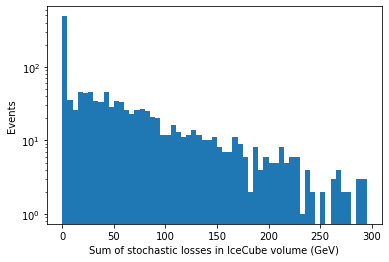

In [253]:
plt.hist(stoch_ar, np.arange(0, 300, 5))
plt.yscale('log')
plt.xlabel('Sum of stochastic losses in IceCube volume (GeV)')
plt.ylabel('Events')

Text(0, 0.5, 'std')

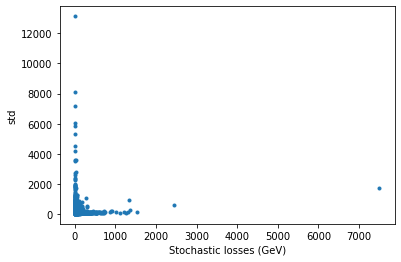

In [255]:
plt.plot(stoch_ar, std_ar, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('std')


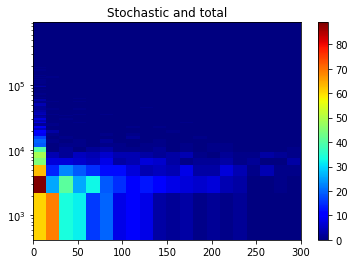

(0.0, 300.0)

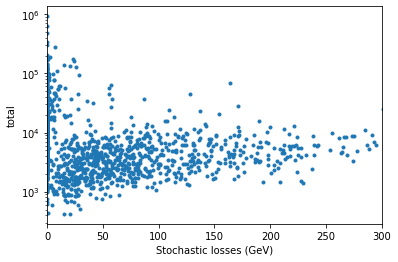

In [257]:
plt.yscale('log')
plt.hist2d(stoch_ar, total_ar , bins=(500, 500), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)

plt.title('Stochastic and total')
plt.show()

plt.yscale('log')
plt.plot(stoch_ar, total_ar , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('total')
plt.xlim(0,300)

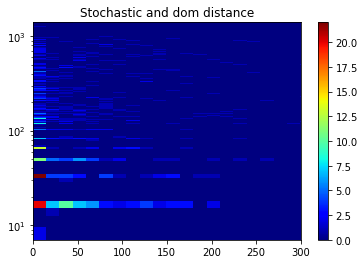

(0.0, 300.0)

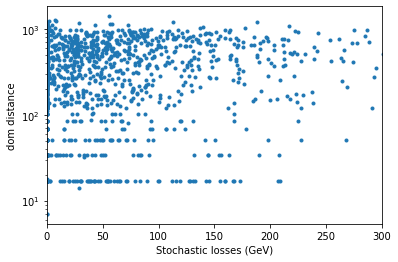

In [258]:
plt.yscale('log')
plt.hist2d(stoch_ar, dist_ar , bins=(500, 500), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)

plt.title('Stochastic and dom distance')
plt.show()

plt.yscale('log')
plt.plot(stoch_ar, dist_ar , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('dom distance')
plt.xlim(0,300)

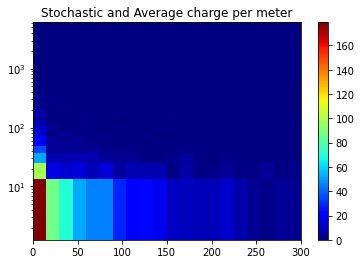

(0.0, 300.0)

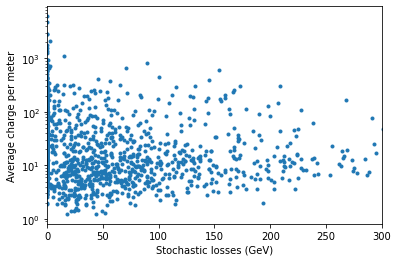

In [259]:
plt.yscale('log')
plt.hist2d(stoch_ar, (total_ar/dist_ar) , bins=(500, 500), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)

plt.title('Stochastic and Average charge per meter')
plt.show()

plt.yscale('log')
plt.plot(stoch_ar, (total_ar/dist_ar) , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('Average charge per meter')
plt.xlim(0,300)

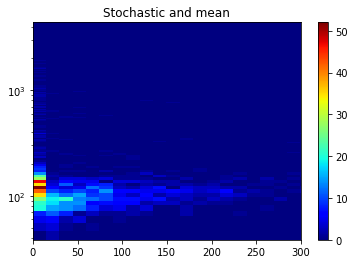

(0.0, 300.0)

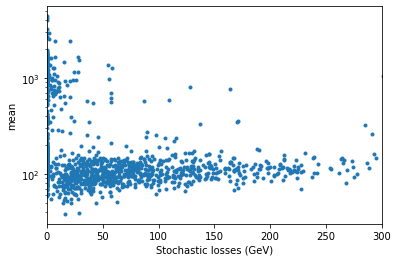

In [260]:
plt.yscale('log')
plt.hist2d(stoch_ar, mean_cor_ar , bins=(500, 500), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)

plt.title('Stochastic and mean')
plt.show()

plt.yscale('log')
plt.plot(stoch_ar, mean_cor_ar , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('mean')
plt.xlim(0,300)

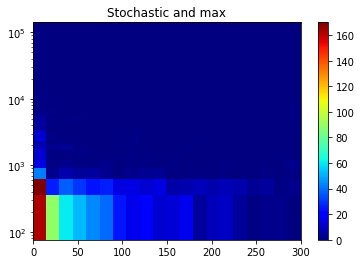

(0.0, 300.0)

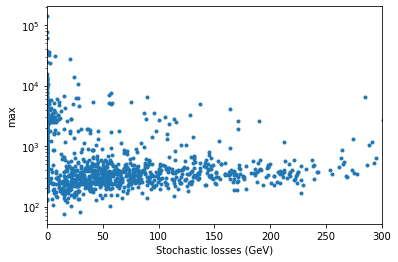

In [261]:
plt.yscale('log')
plt.hist2d(stoch_ar, max_cor_ar , bins=(500, 500), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)

plt.title('Stochastic and max')
plt.show()

plt.yscale('log')
plt.plot(stoch_ar, max_cor_ar , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('max')
plt.xlim(0,300)

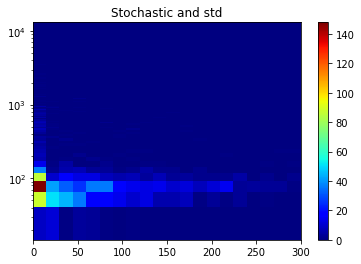

(0.0, 300.0)

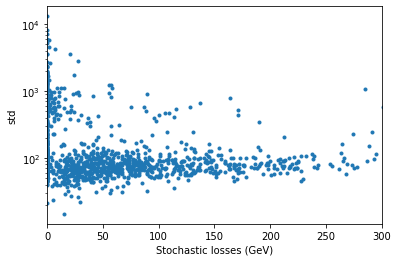

In [262]:
plt.yscale('log')
plt.hist2d(stoch_ar, std_ar , bins=(500, 500), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)

plt.title('Stochastic and std')
plt.show()

plt.yscale('log')
plt.plot(stoch_ar, std_ar , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('std')
plt.xlim(0,300)

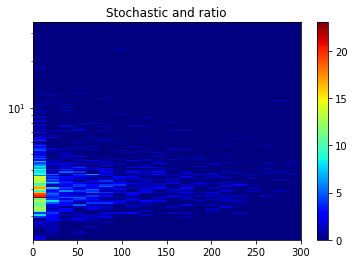

(0.0, 300.0)

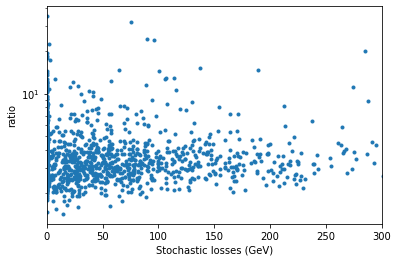

In [263]:
plt.yscale('log')
plt.hist2d(stoch_ar, ratio_ar , bins=(500, 500), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)

plt.title('Stochastic and ratio')
plt.show()

plt.yscale('log')
plt.plot(stoch_ar, ratio_ar , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('ratio')
plt.xlim(0,300)

In [25]:

def inf(num):
    infile = dataio.I3File(os.path.join(files_dir,file_list[num]))
    frame = infile.pop_physics()   
    return frame


In [8]:
print(inf(0))


[ I3Frame  (Physics):
  'AnalysisMuons' [Physics] ==> TreeBase::Tree<I3Particle, I3ParticleID, __gnu_cxx::hash<I3ParticleID> > (174)
  'BackgroundCLSim_intermediatePhotons' [DAQ] ==> I3Map<ModuleKey, I3Vector<I3Photon> > (3167)
  'BackgroundI3MCPESeriesMap_0.990' [DAQ] ==> I3Map<OMKey, vector<I3MCPE> > (90)
  'BackgroundI3MCTree' [DAQ] ==> TreeBase::Tree<I3Particle, I3ParticleID, __gnu_cxx::hash<I3ParticleID> > (1786)
  'BackgroundI3MCTree_preMuonProp' [DAQ] ==> TreeBase::Tree<I3Particle, I3ParticleID, __gnu_cxx::hash<I3ParticleID> > (918)
  'BackgroundMMCTrackList' [DAQ] ==> I3Vector<I3MMCTrack> (304)
  'BeaconLaunches' [DAQ] ==> I3Map<OMKey, vector<I3DOMLaunch> > (46)
  'CalibratedWaveformRange' [DAQ] ==> I3TimeWindow (48)
  'CascadeFilter_13' [Physics] ==> I3PODHolder<bool> (27)
  'CorsikaInteractionHeight' [DAQ] ==> I3PODHolder<double> (36)
  'CorsikaWeightMap' [DAQ] ==> I3Map<string, double> (482)
  'DCAnalysisHits' [Physics] ==> I3PODHolder<double> (36)
  'DCNHits' [Physics] ==> 

In [9]:
pulses = inf(0)['SRTInIcePulsesDOMeff'].apply(inf(0))
one_dom = pulses.items()

In [16]:
charge = []
tim = []
for i in range(16):  #Sasha: I have 16 here, because it is the first time when we met this "triplet" 
    
    
    for pulse in one_dom[i][1]:
        char = 0
        char += pulse.charge
        time = 0
        time += pulse.time
        if len(pulse.time) > 1:
            return 
        print(time) #Sasha: there are three last values of charge
    charge.append(char)#Sasha: they do not write down in this array, only one of them is written.
    tim.append(time)  
        
print(tim)
#Sasha: but in the next cell I consider them as a sum, I mean I will have not 1.17, 0.925, 1.225 separately, but their sum

13869.0
12625.0
12789.0
12678.0
11780.0
12053.0
12582.0
12173.0
12146.0
12162.0
9890.0
10843.0
9958.0
10183.0
9984.0
10004.0
10050.0
10090.0
[13869.0, 12625.0, 12789.0, 12678.0, 11780.0, 12053.0, 12582.0, 12173.0, 12146.0, 12162.0, 9890.0, 10843.0, 9958.0, 10183.0, 9984.0, 10090.0]


In [ ]:
charge = []
for i in range(len(one_dom)):  
    char = 0
    for pulse in one_dom[i][1]:
        char += pulse.charge
        
        
    charge.append(char)
        
print(charge)

In [466]:
gcd_file = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_IC86_Merged.i3.gz'

gfile = dataio.I3File(gcd_file)
gframe = gfile.pop_frame()
print(gframe)
geometry = gframe['I3Geometry']

[ I3Frame  (Geometry):
  'I3Geometry' [Geometry] ==> I3Geometry (641528)
]



In [467]:
mydom = []
for i in range(len(one_dom)):
    dom = geometry.omgeo[one_dom[i][0]]    
    mydom.append(dom)  
    
print(len(mydom))
#print(mydom[0])


51


In [478]:
mmctracks = inf(0)['MMCTrackList']
track = mmctracks[0].particle
print(track)


[ I3Particle MajorID : 13469127016857373990
             MinorID : 846
              Zenith : 0.400847
             Azimuth : 1.80333
                   X : -227.484
                   Y : 1017.22
                   Z : 1949.99
                Time : 3536.68
              Energy : 1054.01
               Speed : 0.299792
              Length : 3125.59
                Type : MuPlus
        PDG encoding : -13
               Shape : StartingTrack
              Status : NotSet
            Location : InIce
]


In [482]:
distance = []
for i in range(len(mydom)):
    d = phys_services.I3Calculator.cherenkov_distance(track, mydom[i].position)
    distance.append(d)
print(len(distance))

51


In [488]:
corrected_charge = []
for i in range(len(distance)):
# This is for adding also the attenuation (absorption + scattering)
    att_length = 50. # Typical attenuation length in icecube
    corrected = charge[i]*distance[i]#*np.exp(distance/att_length)
    corrected_charge.append(corrected)

In [490]:
print(len(corrected_charge))
print(corrected_charge)

51
[222.0763055078901, 167.65234550125294, 90.87879437146664, 70.22624541320249, 32.3280058807941, 87.84635247531457, 58.48567357188964, 43.853323474581885, 199.65093749494238, 205.83572456677518, 101.78875708003031, 20.087685112520425, 56.326474720920636, 63.917247745306305, 30.530444785473144, 91.92426364795048, 14.230792672602277, 84.02980064662638, 145.34649795757636, 111.39816999261477, 420.42546298068703, 200.25207647815236, 175.6844459128978, 94.48273255331011, 161.179778497579, 140.79109625569555, 110.38414462387806, 80.54971137983249, 79.88749828800925, 48.8141967257675, 155.96482979729348, 45.35664547689054, 75.50349198575303, 351.0134498294823, 153.79620421796307, 200.1332633587479, 269.3021013764831, 134.78485505776138, 48.89932423766513, 115.99762021723895, 98.24075255388614, 101.74091060807486, 63.26580603753744, 63.48418668450139, 23.245831617524548, 39.831076130185615, 110.32993059738524, 35.376758412388426, 106.06636885481633, 128.34913355697762, 118.64307049674646]


In [36]:
# Try to put it inside a function so that you can pass the puse series to the function, 
# and obtain a list of corrected charges
# Consider looking only at DOMs "nearby" (within a maximum distance of 150-200m, no further)

In [37]:
phys_services.I3Calculator.closest_approach_distance

<function phys-services.I3Calculator.closest_approach_distance>

In [147]:
nfiles = 2

char = []

for i in range(nfiles):
    with dataio.I3File(os.path.join(files_dir, file_list[i])) as infile:
        for frame in infile:  
            frame = infile.pop_physics()             
            fr.append(frame)
            pulses = frame['SRTInIcePulsesDOMeff'].apply(frame)
        
print(len(pulses))
#print(pulses)
zero = []
one = []


for i in range(len(pulses)):
    one_dom = pulses.popitem()
   
    charge = 0
    for pulse in one_dom[1]:
        charge += pulse.charge
    #print(charge)
    char.append(charge)
    zero.append(one_dom[0])
    one.append(one_dom[1])
    #print(one_dom[0])
    
print(len(char))
#print(char)
#print(zero)

88
88


In [148]:
gcd_file = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_IC86_Merged.i3.gz'

gfile = dataio.I3File(gcd_file)

dom=[]
tr=[]
dist = []


for i in range(nfiles):
    with dataio.I3File(os.path.join(files_dir, file_list[i])) as infile:
        for frame in infile:  
            frame = infile.pop_physics()             
            fr.append(frame)
        
            mmctracks = frame['MMCTrackList']
            track = mmctracks[0].particle
            tr.append(track)
        
        gframe = gfile.pop_frame()    
        geometry = gframe['I3Geometry']

for j in range(len(zero)):
    mydom = geometry.omgeo[zero[j]]
    dom.append(mydom)
           
    distance = phys_services.I3Calculator.cherenkov_distance(track, mydom.position)
    dist.append(distance)
        
print(len(dist))    
print(len(tr))
print(len(dom))

88
2588
88


In [173]:
def cor_char(char, dist):

  corrected_charge = char * dist
  return corrected_charge

cor_char(5,10)

50

50

In [58]:
list_of_char = []

for charge in range(2):
    for distance in range(2):
        list_of_char.append(cor_char(charge,distance))

In [59]:
print(list_of_char)

[0, 0, 0, 1]
